In [373]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
import py3Dmol
from statistics import mean, median,variance,stdev
import seaborn as sns
import pandas as pd
import copy
import numpy as np

In [374]:
max_res_pair_distance = 50

In [390]:
def least_squares_fit(x, y):
    # xとyのデータが同じ長さであることを確認
    if len(x) != len(y):
        raise ValueError("x and y must have the same length")
    
    # 最小二乗フィッティング
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    
    return m, c

def fasta_reader(fasta_file):
    seq_list = []
    f = open(fasta_file)
    for i, line in enumerate(f):
        if i%2 == 1:
            if 'X' in line or 'x' in line or '*' in line:
                continue
            while ' ' in line:
                line = line.replace(' ', '')
            seq_list.append(line.upper().strip())
    return seq_list

def learning_data_reader(fasta_file):
    aa_dic = {'A':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0,'I':0,'K':0,'L':0,'M':0,'N':0,'P':0,'Q':0,'R':0,'S':0,'T':0,'V':0,'W':0,'Y':0}
    seq_list = []
    f = open(fasta_file)
    for i, line in enumerate(f):
        if i%2 == 1:
            non_natural_aa_count = 0
            for aa in line.strip():
                if aa!='b' and aa not in aa_dic:
                    non_natural_aa_count += 1
            if non_natural_aa_count == 0:
                seq_list.append(line.strip())
    
    return seq_list


def aa_counter(seq_list):
    aa_count = {'A':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0,'I':0,'K':0,'L':0,'M':0,'N':0,'P':0,'Q':0,'R':0,'S':0,'T':0,'V':0,'W':0,'Y':0}
    for seq in seq_list:
        for aa in seq:
            aa_count[aa] += 1
    return aa_count


def aa_pair_counter(seq_list, res_pair_distance=1):
    aa_pair = []
    for seq in seq_list:
        if len(seq)<res_pair_distance+1:
            continue
        for aa1, aa2 in zip(seq[0:-1*res_pair_distance], seq[res_pair_distance:]):
            aa_pair.append([aa1, aa2])
    return aa_pair



def aa_count_hist_maker(aa_count_dict, figure_name):
    dict = aa_count_dict
    g = plt.bar([d for d in dict.keys()], dict.values(),color='gray',alpha=0.7,edgecolor='k')
    plt.savefig(figure_name)
    plt.show()

def second_st_rate_checker(AF_result_dir):
    second_st_rates = []
    rank1_pdbs = glob.glob(AF_result_dir+'/*rank_001*.pdb')
    for pdb in rank1_pdbs:
        !stride $pdb > temp.txt
        f = open('temp.txt')
        second_st_rate = 0
        for line in f:
            if 'ASG' in line:
                if line[24] in ['E', 'H']:
                    second_st_rate += 1
        second_st_rate = second_st_rate/100
        second_st_rates.append(second_st_rate)
    return second_st_rates

def strand_rate_checker(AF_result_dir):
    second_st_rates = []
    rank1_pdbs = glob.glob(AF_result_dir+'/*rank_001*.pdb')
    for pdb in rank1_pdbs:
        !stride $pdb > temp.txt
        f = open('temp.txt')
        second_st_rate = 0
        for line in f:
            if 'ASG' in line:
                if line[24] in ['E']:
                    second_st_rate += 1
        second_st_rate = second_st_rate/100
        second_st_rates.append(second_st_rate)
    return second_st_rates


def helix_rate_checker(AF_result_dir):
    second_st_rates = []
    rank1_pdbs = glob.glob(AF_result_dir+'/*rank_001*.pdb')
    for pdb in rank1_pdbs:
        !stride $pdb > temp.txt
        f = open('temp.txt')
        second_st_rate = 0
        for line in f:
            if 'ASG' in line:
                if line[24] in ['H']:
                    second_st_rate += 1
        second_st_rate = second_st_rate/100
        second_st_rates.append(second_st_rate)
    return second_st_rates

def confidence_score_checker(AF_result_dir):
    ptms = []
    plddts = []
    rank1_pdbs = glob.glob(AF_result_dir+'/*rank_001*.pdb')
    for pdb in rank1_pdbs:
        json_f = pdb.replace('.pdb', '.json').replace('unrelaxed', 'scores')
        scores = json.load(open(json_f))
        ptms.append(scores['ptm'])
        plddts.append(sum(scores['plddt'])/len(scores['plddt']))
    return ptms, plddts




def structure_viewer(pdb_path, scale=2):
    print(f'File Path: {pdb_path}')
    json_file = pdb_path.replace('.pdb', '.json').replace('unrelaxed','scores')
    scores = json.load(open(json_file))
    plddt = sum(scores['plddt'])/len(scores['plddt'])
    ptm = scores['ptm']
    print(f'pLDDT: {plddt}, pTM: {ptm}')
    view = py3Dmol.view(width=680*scale, height=250*scale, query=pdb_path, viewergrid=(1,3), linked=False)
    view.setStyle({'stick': {}}, viewer=(0,0))
    view.setStyle({'sphere': {}}, viewer=(0,1))
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}}, viewer=(0,2))
    view.setBackgroundColor('#ebf4fb', viewer=(0,0))
    view.setBackgroundColor('#f9f4fb', viewer=(0,1))
    view.setBackgroundColor('#e1e1e1', viewer=(0,2))
    view.show()
    view.png()


def mat_maker(pre_seq_list, fig_file_name, start_codon_concerning = True, save_fig = True, show_mat_img=True, res_pair_distance=1, sns_off=False): #res_pair_distance : アミノ酸の共起頻度を測る時に、何残基離れたアミノ酸ペアを参照するか
    pseudo_count = 1e-4
    #開始コドンのバイアスを排除するために１残基目をカウントしない
    if start_codon_concerning:
        seq_list = []
        for seq in pre_seq_list:
            seq_list.append(seq[1:])
    else:
        seq_list = pre_seq_list

    aa_dic = {'A':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0,'I':0,'K':0,'L':0,'M':0,'N':0,'P':0,'Q':0,'R':0,'S':0,'T':0,'V':0,'W':0,'Y':0}
    aa_count_dic = aa_counter(seq_list)
    aa_pair_count_dic = {}
    for aa in aa_dic:
        aa_pair_count_dic[aa] = copy.copy(aa_dic)

    all_pair_num = 0
    for aa_pair in aa_pair_counter(seq_list,res_pair_distance=res_pair_distance):
        #print(aa_pair[0], aa_pair[1])
        all_pair_num += 1
        aa_pair_count_dic[aa_pair[0]][aa_pair[1]] += pseudo_count + (sum(list(aa_count_dic.values())))**2/(aa_count_dic[aa_pair[0]]*aa_count_dic[aa_pair[1]])



    for aa1 in aa_dic:
        for aa2 in aa_dic:
            aa_pair_count_dic[aa1][aa2] = np.log(pseudo_count + aa_pair_count_dic[aa1][aa2]/all_pair_num)



    df = pd.DataFrame(aa_pair_count_dic, columns=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'],index=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'])

    if not sns_off:
        sns.heatmap(df,cmap="RdBu",square =True,vmin=-0.15,vmax=0.15,linewidths=.5)
        plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5,17.5,18.5,19.5],['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'],fontweight='bold',fontsize=8)
        plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5,17.5,18.5,19.5],['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'],fontweight='bold',fontsize=8,rotation=90)
        plt.tick_params(bottom=False, left=False, right=False, top=False)
        plt.ylabel(f'i+{res_pair_distance}')
        plt.xlabel('i')
        if save_fig:
            plt.savefig(fig_file_name,dpi=400)
        if show_mat_img:
            plt.show()

    return df
    



def random_seq_generation(max_res_num, seq_num, fasta_file_name):
    generated_seqs = []
    rng = np.random.default_rng()
    w = open(fasta_file_name)
    for i in range(seq_num):
        res_num = rng.integers(max_res_num)
        seq = ''
        for res in range(res_num):
            seq += np.random.choice(['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'])
        generated_seqs.append(seq)
    return generated_seqs

def caluc_KL_div(df_mat_1, df_mat_2):
    pseudo_count = 1e-4
    KL_div = 0
    #共起傾向のままだと負符号のせいでlog計算ができないので、softmaxで規格化する
    df_mat_1_array = []
    df_mat_2_array = []
    for aa1 in ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']:
        for corr_tend_1, corr_tend_2 in zip(df_mat_1[aa1], df_mat_2[aa1]):
            df_mat_1_array.append(corr_tend_1)
            df_mat_2_array.append(corr_tend_2)

    df_mat_1_array = np.array(df_mat_1_array)
    df_mat_2_array = np.array(df_mat_2_array)

    df_mat_1_array = np.exp(df_mat_1_array)/np.sum(np.exp(df_mat_1_array))
    df_mat_2_array = np.exp(df_mat_2_array)/np.sum(np.exp(df_mat_2_array))

    #ここからKL_divの計算
    for normed_corr_tend_1, normed_corr_tend_2 in zip(df_mat_1_array, df_mat_2_array):
        KL_div += normed_corr_tend_1*np.log(pseudo_count + normed_corr_tend_1/normed_corr_tend_2)

    return KL_div

In [376]:
seqs_by_random = random_seq_generation(200, 500, '../fasta/randomly_generated.fasta')

kinase_seqs = fasta_reader('../fasta/kinase_under_400res.fasta')

seqs_from_ECOD = fasta_reader('../fasta/seqs_from_ECOD.fasta')

seqs_by_remade_diffusion = fasta_reader('../fasta/test_generated_2.fasta')
for seq in seqs_by_remade_diffusion:
    if 'B' in seq:
        seqs_by_remade_diffusion.remove(seq)

learning_data_original = np.random.permutation(learning_data_reader('../fasta/train_data_from_AFDB_from100res_to200res.fasta'))
learning_data = learning_data_original[0:1000]

learning_data_parsed = []
for seq in learning_data:    
    seq_parsed = seq
    while 'b' in seq_parsed:
        seq_parsed=seq_parsed.replace('b','')

    learning_data_parsed.append(seq_parsed)


### ***学習の結果、アミノ酸の含有率は結構再現されているっぽい***

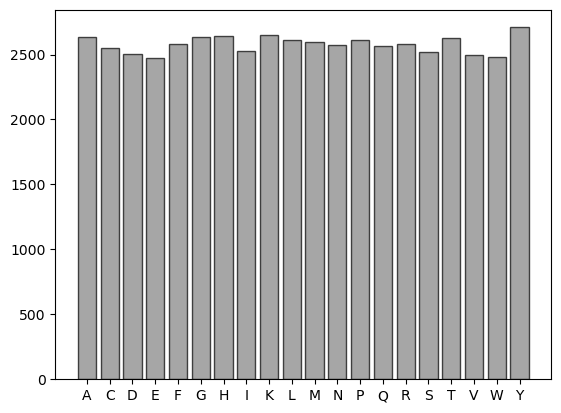

In [377]:
#randomly generated sequences
aa_count_hist_maker(aa_counter(seqs_by_random), '../figure/seqs_by_random.pdf')

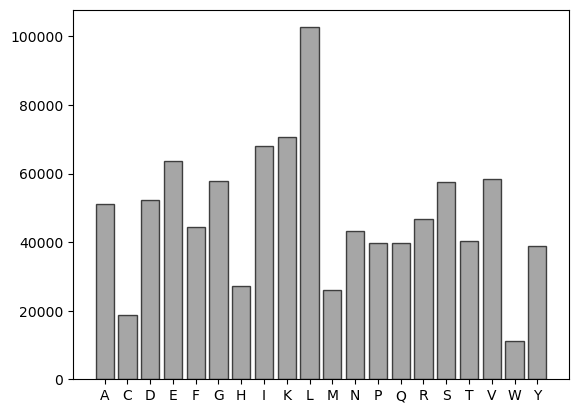

In [378]:
#kinase family sequences
aa_count_hist_maker(aa_counter(kinase_seqs), '../figure/kinase_seqs.pdf')

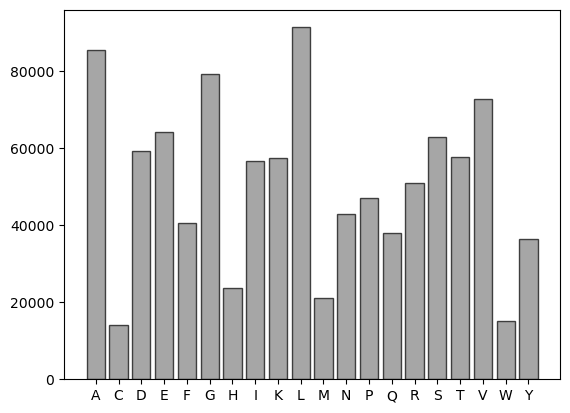

In [379]:
#sequences from ECOD
aa_count_hist_maker(aa_counter(seqs_from_ECOD), '../figure/seqs_from_ECOD.pdf')

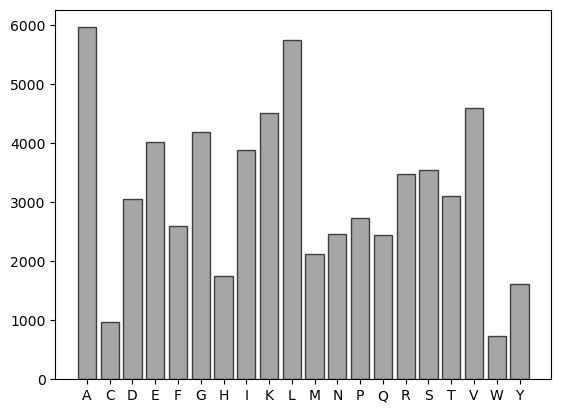

In [380]:
#generated sequences by diffusion
aa_count_hist_maker(aa_counter(seqs_by_remade_diffusion), '../figure/seqs_by_remade_diffusion.pdf')

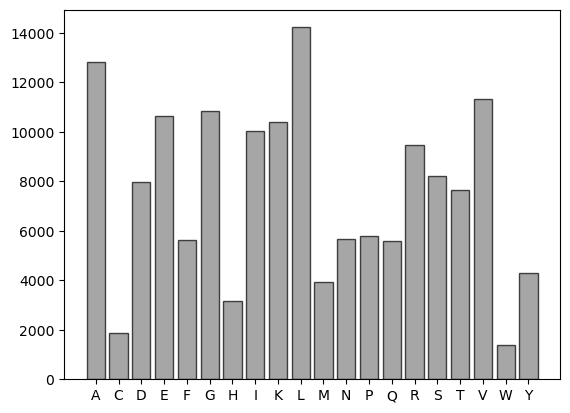

In [381]:
#learning datas
aa_count_hist_maker(aa_counter(learning_data_parsed), '../figure/learning_data_parsed.pdf')

### ***共起頻度の比較***

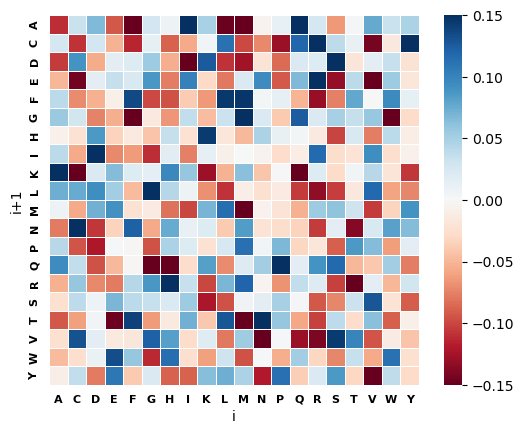

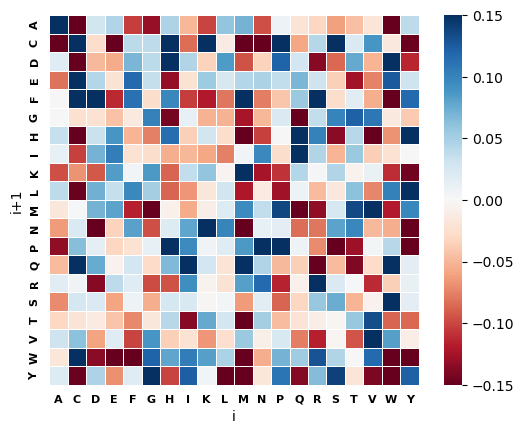

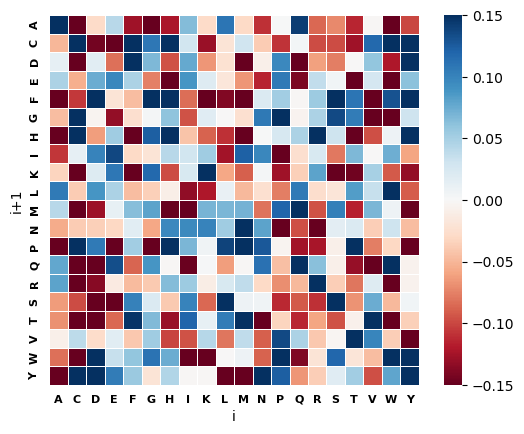

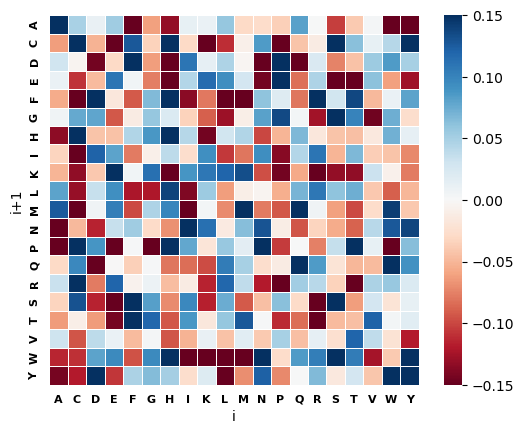

In [382]:
#randomly generated seqs
df_mat_of_seqs_by_random = mat_maker(seqs_by_random, '../figure/df_mat_of_seqs_by_random.pdf')

#generated by diffusion
df_mat_of_seqs_by_remade_diffusion = mat_maker(seqs_by_remade_diffusion, '../figure/df_mat_of_seqs_by_remade_diffusion.pdf')

#seqs in AFDB
df_mat_of_learning_data_randomly_picked_up_parsed = mat_maker(learning_data_parsed, '../figure/df_mat_of_learning_data_randomly_picked_up_parsed.pdf')

#seqs from ECOD 
df_mat_of_seqs_from_ECOD = mat_maker(seqs_from_ECOD, '../figure/df_mat_of_seqs_from_ECOD.pdf')

In [383]:
print('KL_div( seq_by_diffusion | seq_by_random ):',caluc_KL_div(df_mat_of_seqs_by_remade_diffusion, df_mat_of_seqs_by_random))
print('KL_div( seq_by_diffusion | seq_from_AFDB ):',caluc_KL_div(df_mat_of_seqs_by_remade_diffusion, df_mat_of_learning_data_randomly_picked_up_parsed))
print('KL_div( seqs_from_ECOD | seq_from_AFDB ):'  ,caluc_KL_div(df_mat_of_seqs_from_ECOD, df_mat_of_learning_data_randomly_picked_up_parsed))

KL_div( seq_by_diffusion | seq_by_random ): 0.01028496609239654
KL_div( seq_by_diffusion | seq_from_AFDB ): 0.01530316630496258
KL_div( seqs_from_ECOD | seq_from_AFDB ): 0.008238565953806488


In [384]:
max_res_pair_dist = 100

KL_list_diff_AFDB = []
KL_list_ECOD_AFDB = []
for res_pair_distance in range(1,max_res_pair_dist+1):
    KL_diff_AFDB = caluc_KL_div(mat_maker(seqs_by_remade_diffusion,None,save_fig=False,show_mat_img=False,sns_off=True,res_pair_distance=res_pair_distance), mat_maker(learning_data_parsed,None,save_fig=False,show_mat_img=False,sns_off=True,res_pair_distance=res_pair_distance))
    KL_ECOD_AFDB = caluc_KL_div(mat_maker(seqs_from_ECOD,None,save_fig=False,show_mat_img=False,sns_off=True,res_pair_distance=res_pair_distance), mat_maker(learning_data_parsed,None,save_fig=False,show_mat_img=False,sns_off=True,res_pair_distance=res_pair_distance))

    KL_list_diff_AFDB.append(KL_diff_AFDB)
    KL_list_ECOD_AFDB.append(KL_ECOD_AFDB)

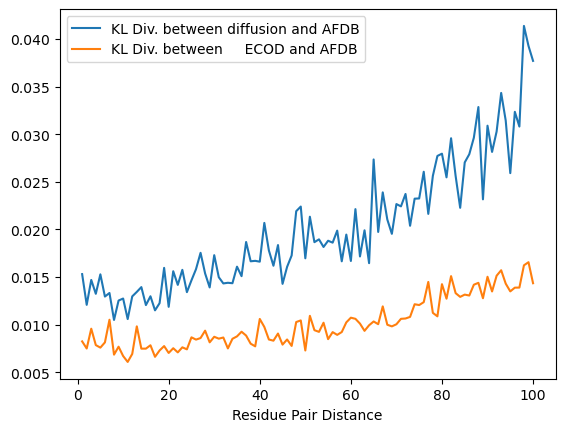

In [391]:
plt.plot(range(1, max_res_pair_dist+1), KL_list_diff_AFDB)
plt.plot(range(1, max_res_pair_dist+1), KL_list_ECOD_AFDB)
KL_list_diff_AFDB_m, KL_list_diff_AFDB_c = least_squares_fit(range(1, max_res_pair_dist+1), KL_list_diff_AFDB)
KL_list_ECOD_AFDB_m, KL_list_ECOD_AFDB_c = least_squares_fit(range(1, max_res_pair_dist+1), KL_list_ECOD_AFDB)
plt.legend(['KL Div. between diffusion and AFDB', 'KL Div. between     ECOD and AFDB'])
plt.xlabel('Residue Pair Distance')

plt.savefig('../figure/KLdiv_ResPairDist.pdf')
plt.show()

In [401]:
round(KL_list_diff_AFDB_m, 4)

0.0002

In [403]:
round(KL_list_ECOD_AFDB_m, 6)

7.7e-05